# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from itertools import product
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [16]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in good_arms+bad_arms}
arm_ids = list(arms.keys())

In [17]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.12973875490046


In [5]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [18]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [19]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 610.0000000000003
random: 277.86000000000007


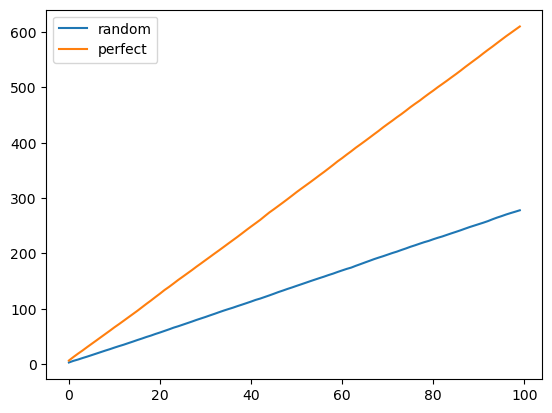

In [20]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.86
random: 2.54


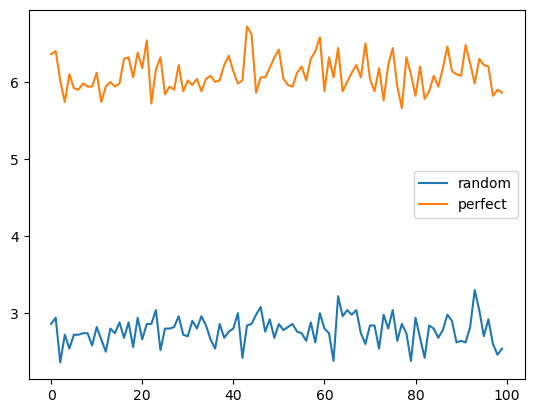

In [21]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [58]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}

    def recommend(self, size):
        target = [
            (arm_id, self.payouts_per_recommendation[arm_id]) for arm_id in arm_ids
        ]
        target_sorted = sorted(target, key=lambda x: x[1], reverse=True)
        target_random = copy(target)
        shuffle(target_random)

        recomendations = []

        for i in range(size):
            x = random()
            if x > self.epsilon:
                recomendations.append(target_sorted[i][0])
            else:
                recomendations.append(target_random[i][0])

        return recomendations

    def feedback(self, arm_id, payout):
        self.recommended_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = (
            self.payouts[arm_id] / self.recommended_rates[arm_id]
        )

In [59]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        # te zera w mianowniku moga byc problematyczne
        # - zastanow sie, czy lepiej je obslugiwac w locie czy zainicjalizowac te mape wartosciami niezerowymi
        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0

    def recommend(self, size):
        target = [
            (
                arm_id,
                self.payouts_per_recommendation[arm_id]
                + self._optimism(arm_id),
            )
            for arm_id in arm_ids
        ]
        target_sorted = sorted(target, key=lambda x: x[1], reverse=True)

        recomendations = []

        for i in range(size):
            recomendations.append(target_sorted[i][0])

        self.n += size
        return recomendations

    def feedback(self, arm_id, payout):
        self.recommended_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = (
            self.payouts[arm_id] / self.recommended_rates[arm_id]
        )

    def _optimism(self, arm_id):
        if self.recommended_rates[arm_id] == 0:
            return 1.0
        return self.optimism_weight * sqrt(log(self.n) / self.recommended_rates[arm_id])

In [69]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1.0 for arm_id in arm_ids}
        self.b = {arm_id: 1.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        target = [
            (
                arm_id,
                betavariate(self.a[arm_id], self.b[arm_id])
            )
            for arm_id in arm_ids
        ]
        target_sorted = sorted(target, key=lambda x: x[1], reverse=True)

        recomendations = []

        for i in range(size):
            recomendations.append(target_sorted[i][0])

        return recomendations
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1-payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - zgrubne porównanie bandytów

In [71]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [72]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ucb_0.01: 6.38
ts_1_20: 6.28
ts_5_5: 6.18
ts_5_10: 6.14
ts_1_1: 6.1
egreedy_0.05: 6.08
perfect: 6.06
ts_10_20: 6.06
ts_10_5: 6.0
ts_10_1: 5.96
ts_50_1: 5.96
egreedy_0.1: 5.94
ucb_0.1: 5.94
ucb_1: 5.94
ts_1_10: 5.9
ucb_10: 5.86
egreedy_0.01: 5.84
ts_1_5: 5.82
ts_1_50: 5.82
ts_20_1: 5.76
ts_20_5: 5.74
ts_5_1: 5.7
ts_20_50: 5.56
ts_5_50: 5.54
ts_20_20: 5.48
ts_10_10: 5.44
ts_20_10: 5.28
ts_10_50: 5.16
ts_50_5: 5.16
ts_50_50: 5.1
egreedy_0.25: 5.04
ts_5_20: 5.04
ts_50_10: 5.04
ts_50_20: 4.66
random: 2.7


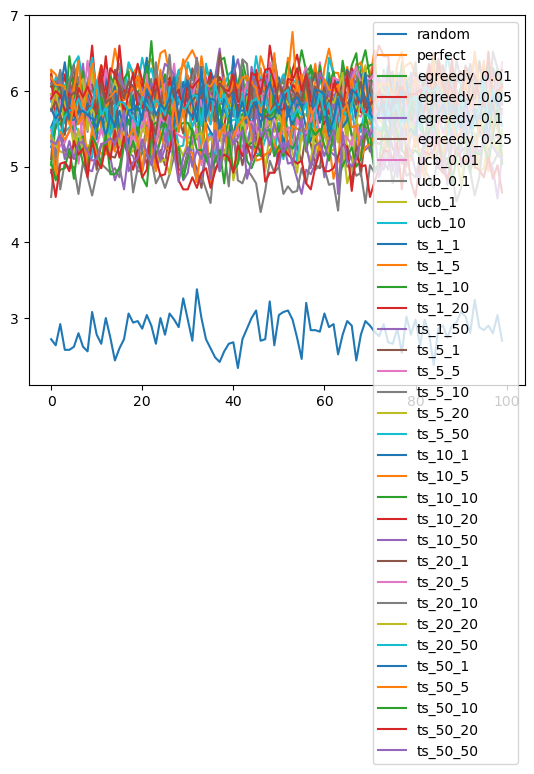

In [73]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 614.3
ucb_10: 610.6000000000001
egreedy_0.01: 608.4000000000002
ts_5_10: 603.2999999999998
ts_10_5: 602.5600000000001
ts_1_50: 601.84
ts_1_10: 600.4999999999997
ts_1_20: 599.4200000000001
egreedy_0.05: 597.8800000000001
ts_10_20: 597.62
ts_5_1: 597.3799999999998
ts_1_5: 595.6400000000002
ts_1_1: 593.7000000000002
ts_5_5: 590.7400000000002
ucb_0.01: 584.7
ts_20_1: 583.7600000000002
ucb_0.1: 582.5600000000002
ts_20_50: 576.2400000000001
ts_5_20: 575.0799999999998
ts_50_1: 574.9799999999999
egreedy_0.1: 573.5600000000002
ts_10_1: 567.9400000000002
ucb_1: 566.3599999999999
ts_10_10: 549.9000000000001
ts_5_50: 548.46
ts_20_5: 544.2999999999997
ts_50_5: 535.4200000000001
ts_20_20: 530.5600000000001
ts_50_50: 524.2999999999997
egreedy_0.25: 524.2799999999999
ts_50_10: 521.2
ts_10_50: 514.3199999999998
ts_50_20: 504.44000000000005
ts_20_10: 493.7800000000001
random: 282.55999999999995


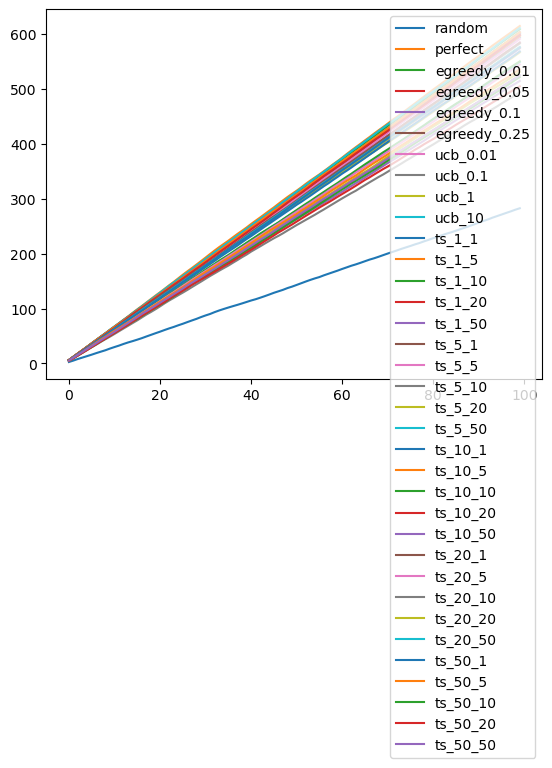

In [74]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [76]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    score = 0
    for recommended_arm in recommendation:
        if recommended_arm.arm_id.startswith("good"):
            score += 1

    return score

all_relevant = relevant(arms.values())
all_relevant

10

In [77]:
# obliczmy precision@k i recall@k (zgodnie ze wzorami z wykladu)
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / relevant(recommendation)

In [78]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.5


In [82]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)

chosen_bandits = ["perfect", "ucb_10", "egreedy_0.01", "ts_5_10", "ts_10_5"]
testing_bandits = [bandit for bandit in bandits if bandit.bandit_id in chosen_bandits]

# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, wypisujemy srednie wartosci
# powtarzamy dla kazdego k
for k in k_vals:
    print(f'k_value: {k}')
    for bandit in testing_bandits:
        recommendation_ids = bandit.recommend(samples)
        recommendation = [arms[arm_id] for arm_id in recommendation_ids]

        print(f'Precision@{k} for bandit {bandit.bandit_id}: {precision_at_k(recommendation, k)}')
        print(f'Recall@{k} for bandit {bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

k_value: 3
Precision@3 for bandit perfect: 1.0
Recall@3 for bandit perfect: 0.3
Precision@3 for bandit egreedy_0.01: 1.0
Recall@3 for bandit egreedy_0.01: 0.3
Precision@3 for bandit ucb_10: 0.6666666666666666
Recall@3 for bandit ucb_10: 0.2222222222222222
Precision@3 for bandit ts_5_10: 1.0
Recall@3 for bandit ts_5_10: 0.3
Precision@3 for bandit ts_10_5: 1.0
Recall@3 for bandit ts_10_5: 0.3
k_value: 5
Precision@5 for bandit perfect: 1.0
Recall@5 for bandit perfect: 0.5
Precision@5 for bandit egreedy_0.01: 1.0
Recall@5 for bandit egreedy_0.01: 0.5
Precision@5 for bandit ucb_10: 0.8
Recall@5 for bandit ucb_10: 0.4444444444444444
Precision@5 for bandit ts_5_10: 1.0
Recall@5 for bandit ts_5_10: 0.5
Precision@5 for bandit ts_10_5: 1.0
Recall@5 for bandit ts_10_5: 0.5
k_value: 10
Precision@10 for bandit perfect: 1.0
Recall@10 for bandit perfect: 1.0
Precision@10 for bandit egreedy_0.01: 1.0
Recall@10 for bandit egreedy_0.01: 1.0
Precision@10 for bandit ucb_10: 0.9
Recall@10 for bandit ucb_10